In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

## a. Load data and set up training / testing sets

In [2]:
%%time
df_train_test = pd.read_pickle('../processed_data/df_train_test.pkl')

Wall time: 500 ms


In [3]:
%%time
X_train = df_train_test[df_train_test['type'] == 0].drop(columns='type')
y_train = X_train['target']
X_train.drop(columns='target', inplace=True)
X_test = df_train_test[df_train_test['type'] == 1].drop(columns=['target','type']).reset_index(drop=True)

Wall time: 664 ms


In [4]:
X_train.head()

,card_id,feature_3,first_active_month,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,elapsed_time,transactions_count,authorized_flag_sum,authorized_flag_mean,city_id_nunique,category_1_sum,category_1_mean,category_2_1.0_mean,category_2_2.0_mean,category_2_3.0_mean,category_2_4.0_mean,category_2_5.0_mean,category_3_A_mean,category_3_B_mean,category_3_C_mean,installments_sum,installments_mean,installments_max,installments_min,installments_std,merchant_category_id_nunique,merchant_id_nunique,purchase_amount_sum,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_std,purchase_date_min,purchase_date_max,state_id_nunique,subsector_id_nunique,purchase_month_nunique,purchase_year_nunique,dayofweek_nunique,weekend_sum,weekend_mean,month_lag_mean,month_lag_max,month_lag_min,month_lag_std,month_diff_mean,month_diff_max,month_diff_min,month_diff_std
0,C_ID_92a2005557,1,2017-06-01,0,0,0,0,1,0,1,0,245.0,260,247,0.950000,7,0,0.000000,0.988462,0.0,0.0,0.000000,0.011538,0.984615,0.015385,0.000000,4,0.015385,1,0,0.123314,41,94,-165.968739,-0.638341,2.258395,-0.739395,0.212139,2017-06-27 14:18:08,2018-02-25 09:31:15,3,21,9,2,7,90,0.346154,-3.911538,0,-8,2.397687,16.311538,17,16,0.464015
1,C_ID_3d0044924f,0,2017-01-01,0,0,0,1,0,1,0,0,396.0,350,339,0.968571,9,31,0.088571,0.911429,0.0,0.0,0.000000,0.000000,0.000000,0.788571,0.205714,543,1.551429,10,-1,1.510777,57,142,-210.006336,-0.600018,4.630299,-0.742400,0.384967,2017-01-06 16:29:42,2018-01-31 22:31:09,3,24,12,2,7,132,0.377143,-5.031429,0,-12,3.804934,17.305714,18,17,0.461369
2,C_ID_d639edf6cd,0,2016-08-01,0,1,0,0,0,0,1,0,549.0,43,41,0.953488,5,0,0.000000,0.093023,0.0,0.0,0.000000,0.906977,1.000000,0.000000,0.000000,0,0.000000,0,0,0.000000,8,13,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,2017-01-11 08:21:22,2018-02-27 19:08:25,2,7,10,2,7,11,0.255814,-8.604651,0,-13,3.842987,16.232558,17,16,0.427463
3,C_ID_186d6a6901,0,2017-09-01,0,0,0,1,0,0,0,1,153.0,77,77,1.000000,7,12,0.155844,0.155844,0.0,0.0,0.688312,0.000000,0.000000,0.883117,0.090909,84,1.090909,3,-1,0.588974,25,50,-49.491364,-0.642745,1.445596,-0.740897,0.261624,2017-09-26 16:22:21,2018-02-28 11:44:40,5,13,6,2,7,11,0.142857,-2.831169,0,-5,1.802065,16.285714,17,16,0.454716
4,C_ID_cdbd2c0db2,0,2017-11-01,1,0,0,0,0,0,0,1,92.0,133,128,0.962406,6,15,0.112782,0.075188,0.0,0.0,0.804511,0.007519,0.000000,0.947368,0.052632,182,1.368421,12,1,1.896862,26,66,-48.687656,-0.366073,7.193041,-0.746156,1.352094,2017-11-12 00:00:00,2018-02-28 20:40:41,6,17,4,2,7,42,0.315789,-1.285714,0,-3,1.026700,16.278195,17,16,0.449804


In [5]:
y_train.head()

0   -0.820283
1    0.392913
2    0.688056
3    0.142495
4   -0.159749
Name: target, dtype: float64

In [6]:
X_test.head()

,card_id,feature_3,first_active_month,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,elapsed_time,transactions_count,authorized_flag_sum,authorized_flag_mean,city_id_nunique,category_1_sum,category_1_mean,category_2_1.0_mean,category_2_2.0_mean,category_2_3.0_mean,category_2_4.0_mean,category_2_5.0_mean,category_3_A_mean,category_3_B_mean,category_3_C_mean,installments_sum,installments_mean,installments_max,installments_min,installments_std,merchant_category_id_nunique,merchant_id_nunique,purchase_amount_sum,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_std,purchase_date_min,purchase_date_max,state_id_nunique,subsector_id_nunique,purchase_month_nunique,purchase_year_nunique,dayofweek_nunique,weekend_sum,weekend_mean,month_lag_mean,month_lag_max,month_lag_min,month_lag_std,month_diff_mean,month_diff_max,month_diff_min,month_diff_std
0,C_ID_0ab67a22ab,1,2017-04-01,0,0,1,0,0,0,0,1,306.0,68,44,0.647059,7,23,0.338235,0.661765,0.0,0.000000,0.000000,0.000000,0.0,0.676471,0.323529,141,2.073529,12,1,2.061127,16,24,-40.733733,-0.599025,0.235676,-0.743902,0.192268,2017-04-04 18:22:24,2017-12-29 01:05:24,3,12,9,1,7,12,0.176471,-3.632353,0,-8,2.454994,18.352941,19,18,0.481438
1,C_ID_130fd0cbdd,0,2017-01-01,0,1,0,0,0,0,0,1,396.0,78,77,0.987179,4,2,0.025641,0.000000,0.0,0.012821,0.961538,0.000000,0.0,0.974359,0.025641,83,1.064103,4,1,0.405794,16,27,-49.136513,-0.629955,0.318817,-0.731881,0.154999,2017-01-13 15:31:38,2018-02-18 21:30:11,3,12,5,2,7,17,0.217949,-10.410256,0,-13,2.164866,16.282051,17,16,0.452911
2,C_ID_b709037bc5,1,2017-08-01,0,0,0,0,1,1,0,0,184.0,13,9,0.692308,4,1,0.076923,0.076923,0.0,0.000000,0.000000,0.846154,0.0,0.076923,0.692308,44,3.384615,10,-1,3.686427,8,9,4.528840,0.348372,2.525866,-0.536537,0.906547,2017-08-25 14:55:37,2018-02-02 18:57:03,4,6,6,2,4,0,0.000000,-2.076923,0,-6,1.754116,16.692308,17,16,0.480384
3,C_ID_d27d835a9f,0,2017-12-01,0,1,0,0,0,1,0,0,62.0,26,26,1.000000,1,0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.653846,0.269231,38,1.461538,6,-1,1.475961,18,23,-13.690715,-0.526566,0.087965,-0.731881,0.219162,2017-12-04 12:55:13,2018-02-20 11:42:39,1,11,3,2,7,7,0.269231,-1.230769,0,-2,0.951113,16.423077,17,16,0.503831
4,C_ID_2b5e3df5c2,1,2015-12-01,0,0,0,0,1,1,0,0,793.0,110,87,0.790909,5,0,0.000000,0.036364,0.0,0.045455,0.918182,0.000000,0.0,0.945455,0.054545,120,1.090909,4,1,0.439880,31,47,25.139384,0.228540,15.782255,-0.746758,2.777764,2017-01-03 11:50:27,2018-02-27 10:42:04,4,15,12,2,7,21,0.190909,-6.227273,0,-13,4.530547,16.427273,17,16,0.496946


## b. Set up an LGB model and do cross-validation

In [7]:
param = {'num_leaves': 100,
         'min_data_in_leaf': 150, 
         'objective':'regression',
         'max_depth': 10,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.75,
         "bagging_freq": 1,
         "bagging_fraction": 0.70,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

features = [x for x in X_train.columns if x not in ['card_id', 'first_active_month','purchase_date_min','purchase_date_max']]
categorical_features = ['feature_3']

In [8]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    print("fold %2d" % fold_ )
    
    # set up lgb dataset
    train_data = lgb.Dataset(X_train.iloc[train_idx][features],
                             label=y_train.iloc[train_idx],
                             categorical_feature=categorical_features
                            )
    val_data = lgb.Dataset(X_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx],
                           categorical_feature=categorical_features
                          )

    num_round = 10000
    clf = lgb.train(param,
                    train_data,
                    num_round,
                    valid_sets = [train_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV score: {:<8.5f}".format(mean_squared_error(oof, y_train)**0.5))

fold  0


C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75063	valid_1's rmse: 3.80391
[200]	training's rmse: 3.70221	valid_1's rmse: 3.77587
[300]	training's rmse: 3.67243	valid_1's rmse: 3.76526
[400]	training's rmse: 3.65109	valid_1's rmse: 3.76125
[500]	training's rmse: 3.63322	valid_1's rmse: 3.75986
[600]	training's rmse: 3.61882	valid_1's rmse: 3.75987
[700]	training's rmse: 3.60657	valid_1's rmse: 3.75989
[800]	training's rmse: 3.59553	valid_1's rmse: 3.76032
Early stopping, best iteration is:
[644]	training's rmse: 3.61286	valid_1's rmse: 3.75971
fold  1


C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75378	valid_1's rmse: 3.7937
[200]	training's rmse: 3.7049	valid_1's rmse: 3.76471
[300]	training's rmse: 3.67471	valid_1's rmse: 3.75351
[400]	training's rmse: 3.6531	valid_1's rmse: 3.74928
[500]	training's rmse: 3.63526	valid_1's rmse: 3.74773
[600]	training's rmse: 3.61969	valid_1's rmse: 3.7471
[700]	training's rmse: 3.60626	valid_1's rmse: 3.74738
[800]	training's rmse: 3.59448	valid_1's rmse: 3.74782
Early stopping, best iteration is:
[637]	training's rmse: 3.61452	valid_1's rmse: 3.74699
fold  2


C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72604	valid_1's rmse: 3.90998
[200]	training's rmse: 3.67854	valid_1's rmse: 3.87913
[300]	training's rmse: 3.64925	valid_1's rmse: 3.86624
[400]	training's rmse: 3.6282	valid_1's rmse: 3.86114
[500]	training's rmse: 3.6119	valid_1's rmse: 3.85929
[600]	training's rmse: 3.59727	valid_1's rmse: 3.85849
[700]	training's rmse: 3.58487	valid_1's rmse: 3.85829
[800]	training's rmse: 3.5744	valid_1's rmse: 3.85843
[900]	training's rmse: 3.56435	valid_1's rmse: 3.85846
Early stopping, best iteration is:
[737]	training's rmse: 3.58092	valid_1's rmse: 3.8582
fold  3


C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.78301	valid_1's rmse: 3.66977
[200]	training's rmse: 3.73293	valid_1's rmse: 3.64556
[300]	training's rmse: 3.70234	valid_1's rmse: 3.63751
[400]	training's rmse: 3.68103	valid_1's rmse: 3.63533
[500]	training's rmse: 3.66396	valid_1's rmse: 3.63499
[600]	training's rmse: 3.64893	valid_1's rmse: 3.63527
[700]	training's rmse: 3.63671	valid_1's rmse: 3.63565
Early stopping, best iteration is:
[501]	training's rmse: 3.66381	valid_1's rmse: 3.63499
fold  4


C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.77235	valid_1's rmse: 3.71635
[200]	training's rmse: 3.72382	valid_1's rmse: 3.68993
[300]	training's rmse: 3.69409	valid_1's rmse: 3.68045
[400]	training's rmse: 3.67267	valid_1's rmse: 3.67666
[500]	training's rmse: 3.65519	valid_1's rmse: 3.67538
[600]	training's rmse: 3.63974	valid_1's rmse: 3.67538
[700]	training's rmse: 3.62606	valid_1's rmse: 3.67609
Early stopping, best iteration is:
[547]	training's rmse: 3.64771	valid_1's rmse: 3.67525
CV score: 3.73582 


Text(0.5,1,'LightGBM Features (avg over folds)')

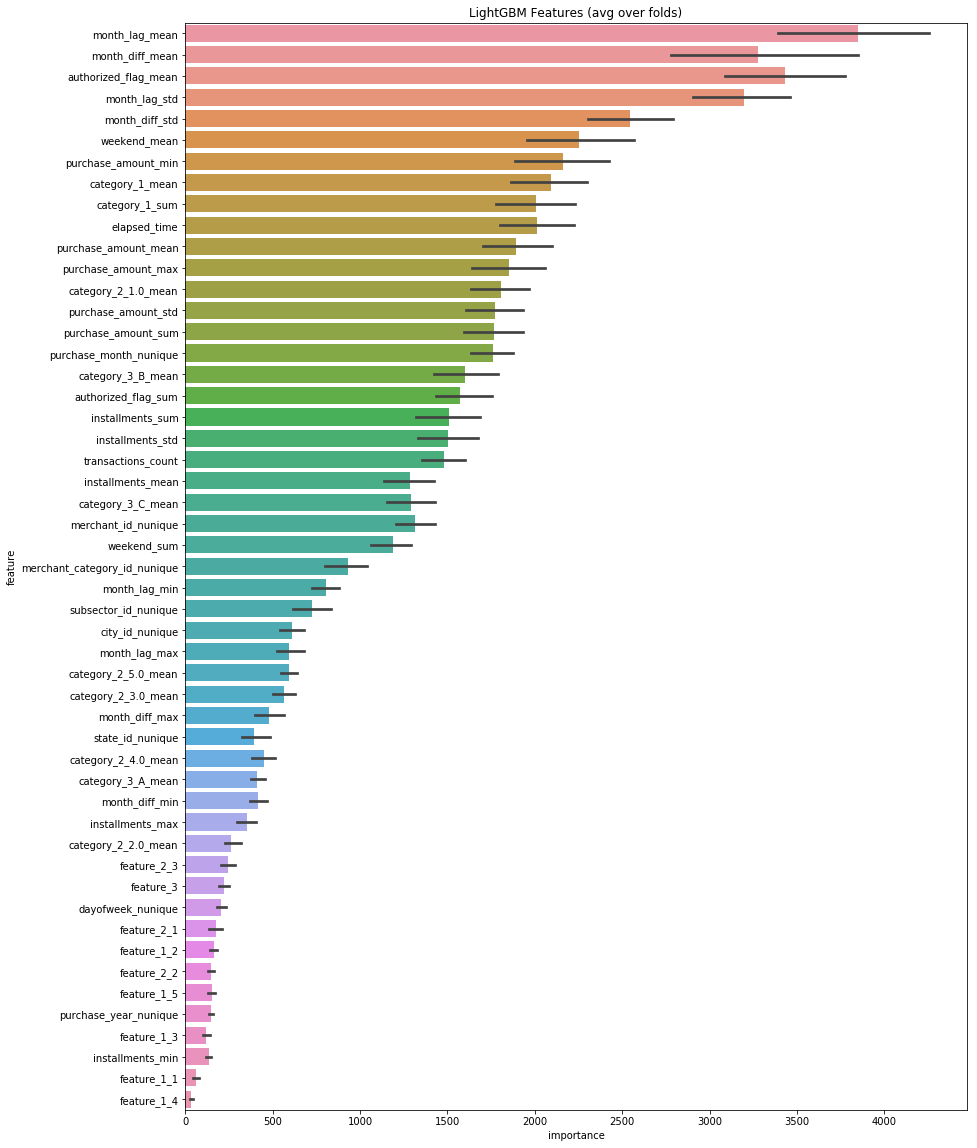

In [9]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,20))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')

## c. Create submission

In [10]:
sub_df = pd.DataFrame({"card_id": X_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("../submission/submit.csv", index=False)